# Additional Modelling Challenges

## Resource-Constrained Project Scheduling Problem

Given

- the durations of the jobs,
- their resource needs,
- the resource capacities, and
- the precedence constraints between the jobs,

determine the start times of the jobs that minimize the makespan while satisfying all constraints. In particular:

1. Each job may have precedence constraints, meaning certain jobs must be completed before others can start.
2. Additionally, there are multiple types of resources, each with a limited capacity that must not be exceeded at any time.

In [1]:
import cpmpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
durations = cp.cpm_array([1, 3, 2, 5, 4, 2, 3, 4, 2, 4, 6, 1])
resource_needs = cp.cpm_array([[0, 0], [5, 1], [0, 4], [1, 4], [1, 3], [3, 2],
                               [3, 1], [2, 4], [4, 0], [5, 2], [2, 5], [0, 0]])
resource_capacities = cp.cpm_array([6, 8])
successors_link = cp.cpm_array([[0, 1], [0, 2], [0, 3], [1, 4], [1, 5], [2, 9], [2, 11],
                                [3, 8], [4, 6], [4, 7], [5, 9], [5, 11], [6, 8], [6, 9], [7, 8], [8, 10], [9, 10], [11, 10]])

print(f"{len(durations) = }, {len(resource_needs) = }, {len(resource_capacities) = }, {len(successors_link) = }")

# Decision variables
start_time = cp.intvar(0, sum(durations), shape=len(durations))
end_times = cp.intvar(0, sum(durations), shape=len(durations))

model = cp.Model()

# Constraints
for r in range(len(resource_capacities)):
    model += cp.Cumulative(start_time, durations, end_times, resource_needs[:, r], resource_capacities[r])

# break the (instance) symmetries
model += cp.IncreasingStrict(start_time[0:4])
model += cp.IncreasingStrict(start_time[4:8])
model += cp.IncreasingStrict(start_time[8:12])

# dominance: last task will be the longest task
model += start_time[3] < start_time[11]

# minimize total execution time
model.minimize(cp.Maximum(start_time))

len(durations) = 12, len(resource_needs) = 12, len(resource_capacities) = 2, len(successors_link) = 18


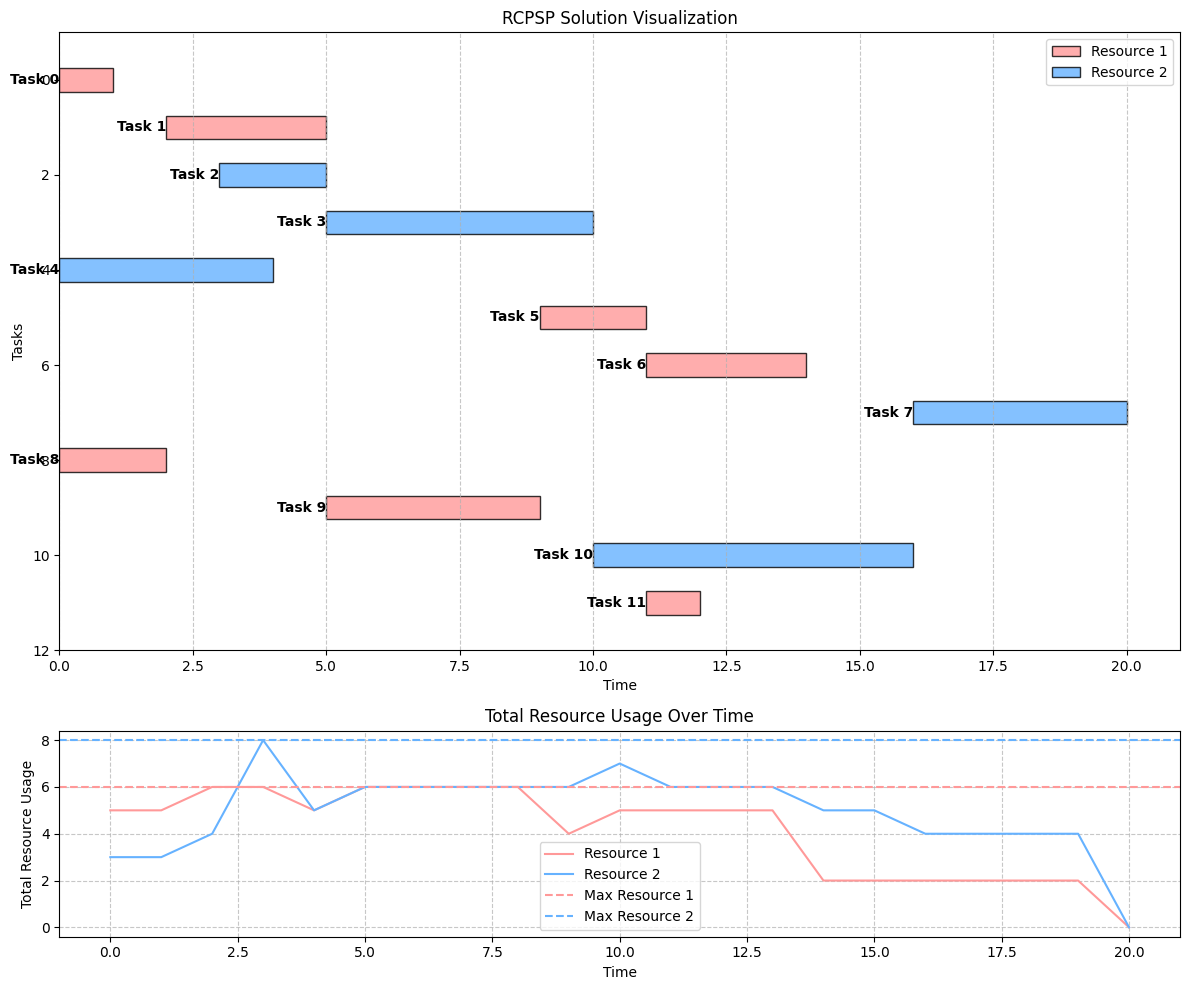

Makespan: 20


In [2]:
# Visualize the RCPSP solution

nb_resource = len(resource_capacities)
nb_jobs = len(durations)

model.solve()
# Get the solution values
start_times = start_time.value()
end_times = start_times + np.array(durations)

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Define colors for each resource
colors = ['#FF9999', '#66B2FF']

# Plot each task as a horizontal bar
for resource in range(nb_jobs):
    if durations[resource] > 0:  # Skip tasks with zero duration
        ax1.barh(resource, durations[resource], left=start_times[resource], height=0.5,
                 color=colors[np.argmax(resource_needs[resource])],
                 alpha=0.8, edgecolor='black')

        # Add task labels
        ax1.text(start_times[resource], resource, f'Task {resource}', va='center', ha='right', fontweight='bold')

# Customize the task plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Tasks')
ax1.set_title('RCPSP Solution Visualization')
ax1.set_ylim(-1, nb_jobs)
ax1.invert_yaxis()  # Invert y-axis to have task 0 at the top

# Add a legend for tasks
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black', alpha=0.8, label=f'Resource {i+1}') for i in range(nb_resource)]
ax1.legend(handles=legend_elements, loc='upper right')

# Show the grid for tasks
ax1.grid(True, axis='x', linestyle='--', alpha=0.7)

# Calculate total resource usage over time
max_time = max(end_times)
resource_usage = np.zeros((nb_resource, max_time + 1))
for resource in range(nb_jobs):
    for t in range(start_times[resource], end_times[resource]):
        for r in range(nb_resource):
            resource_usage[r, t] += resource_needs[resource, r]

# Plot total resource usage
for r in range(nb_resource):
    ax2.plot(range(max_time + 1), resource_usage[r], label=f'Resource {r+1}', color=colors[r])

# Plot maximal allowed usage
for r in range(nb_resource):
    ax2.axhline(y=resource_capacities[r], color=colors[r], linestyle='--',
                label=f'Max Resource {r+1}')

ax2.set_xlabel('Time')
ax2.set_ylabel('Total Resource Usage')
ax2.set_title('Total Resource Usage Over Time')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the makespan (total project duration)
print(f"Makespan: {max(end_times)}")
